<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [3]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

from tqdm.notebook import tqdm

sns.set(style="darkgrid", font_scale=1.4)

#для воспроизводимости результатов
import random

random.seed(777)
np.random.seed(777)
torch.manual_seed(777)
torch.cuda.manual_seed(777)
torch.backends.cudnn.deterministic = True

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [4]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

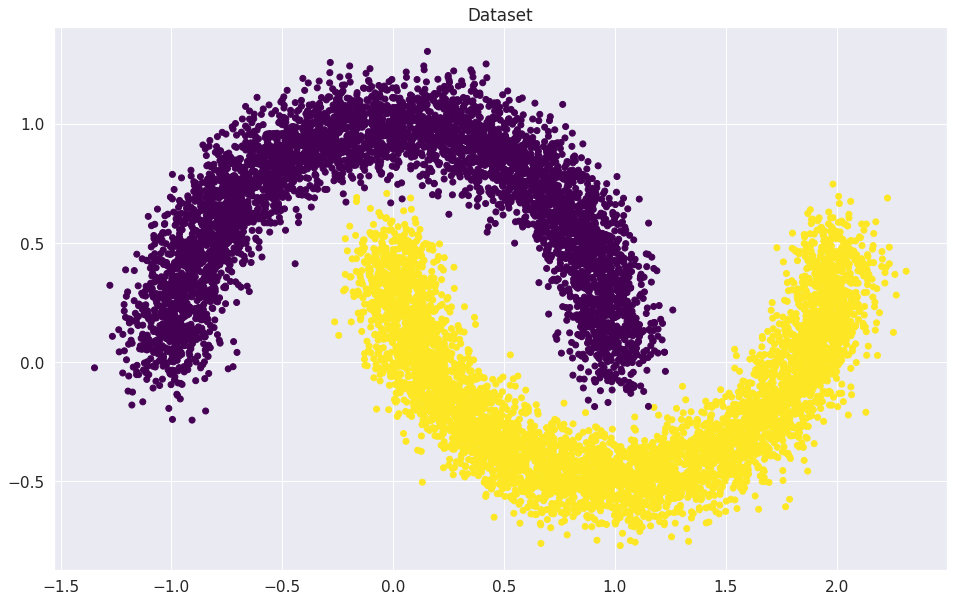

In [5]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [7]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)

In [8]:
assert y_val_t.dtype == torch.float32
assert X_val_t.dtype == torch.float32
assert y_train_t.dtype == torch.float32
assert X_train_t.dtype == torch.float32

Создаем `Dataset` и `DataLoader`. 

In [9]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [10]:
next(iter(train_dataset)) #just checkin'

(tensor([ 0.5020, -0.3376]), tensor(1.))

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [11]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x.squeeze()

In [12]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [13]:
model_params = [*linear_regression.parameters()]
print('Parameters of the model:', model_params)
print(f'Number of parameters: {sum(p.numel() for p in linear_regression.parameters() if p.requires_grad)}')

Parameters of the model: [Parameter containing:
tensor([[-0.4015],
        [-0.5934]], requires_grad=True), Parameter containing:
tensor([1.6885], requires_grad=True)]
Number of parameters: 3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [16]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in tqdm(range(max_epochs)):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch)# YOUR CODE. Use linear_regression to get outputs
        loss = loss_function(outp, y_batch)# YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = outp.sigmoid() # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 637

### Визуализируем результаты

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

NameError: name 'losses' is not defined

<Figure size 864x576 with 0 Axes>

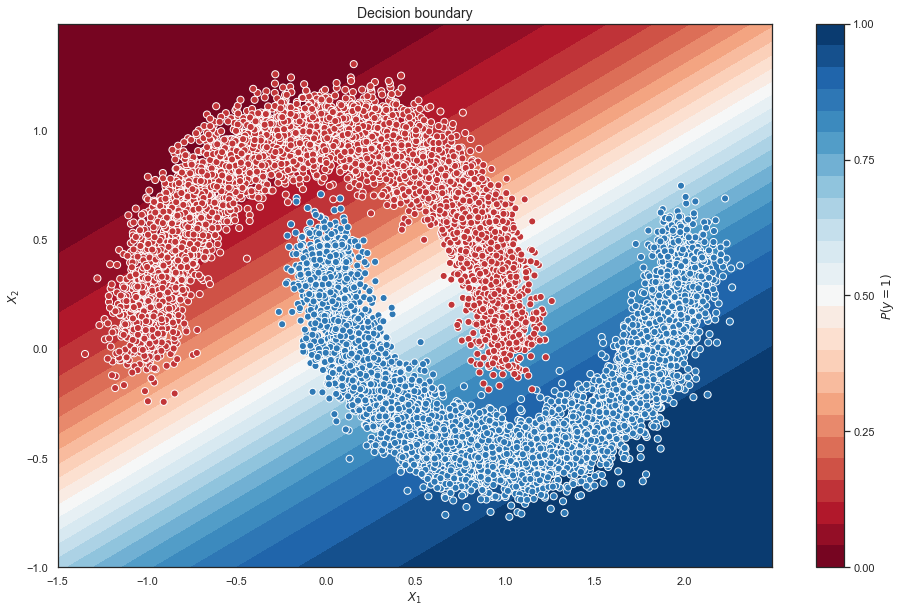

In [16]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = linear_regression.forward(x_batch).sigmoid() > 0.5
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [19]:
y_val_pred = predict(dataloader=val_dataloader, model=linear_regression)

In [20]:
y_train_pred = predict(dataloader=train_dataloader, model=linear_regression)

print(accuracy_score(y_train_t, y_train_pred))

0.8534666666666667


In [21]:
accuracy_score(y_val_t, y_val_pred)

0.862

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.862

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [22]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as T

data_tfs = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5), (0.5))
])

In [23]:
# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

In [24]:
len(train_dataset), len(val_dataset)

(60000, 10000)

target:  5


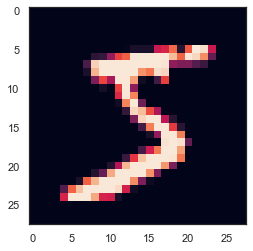

In [27]:
plt.imshow(train_dataset[0][0].numpy().reshape(28, 28))
print('target: ', (train_dataset[0][1]))

In [28]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64)
valid_dataloader = DataLoader(dataset=train_dataset, batch_size=64)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [29]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 ** 2, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10),
    
)

In [30]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
               ELU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
               ELU-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
               ELU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.51
Estimated Total Size (MB): 0.53
----------------------------------------------------------------


In [31]:
criterion = nn.CrossEntropyLoss()   #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [33]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:

            if k == "train":
                optimizer.zero_grad()
                model.train() #train mode on
                outp = model.forward(x_batch)
            else:
                model.eval() #train mode off
                with torch.no_grad(): #for faster calculations
                    outp = model.forward(x_batch)

            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum().item() #number of right answers for current batch
            all = len(x_batch) #number of objects in c batch
            epoch_correct += correct
            epoch_all += all

            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step() #updates the weights
                
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8955833333333333
Loader: valid. Accuracy: 0.9307333333333333
Epoch: 2
Loader: train. Accuracy: 0.9527166666666667
Loader: valid. Accuracy: 0.95275
Epoch: 3
Loader: train. Accuracy: 0.9644333333333334
Loader: valid. Accuracy: 0.9507
Epoch: 4
Loader: train. Accuracy: 0.97065
Loader: valid. Accuracy: 0.9726666666666667
Epoch: 5
Loader: train. Accuracy: 0.9738333333333333
Loader: valid. Accuracy: 0.9683166666666667
Epoch: 6
Loader: train. Accuracy: 0.97725
Loader: valid. Accuracy: 0.9789
Epoch: 7
Loader: train. Accuracy: 0.9801666666666666
Loader: valid. Accuracy: 0.9798
Epoch: 8
Loader: train. Accuracy: 0.9816333333333334
Loader: valid. Accuracy: 0.98045
Epoch: 9
Loader: train. Accuracy: 0.9825166666666667
Loader: valid. Accuracy: 0.9834
Epoch: 10
Loader: train. Accuracy: 0.9845
Loader: valid. Accuracy: 0.9850333333333333


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [34]:
elu_accuracy = accuracy["valid"]

In [35]:
def get_model(activation):
    acts = {'ReLU': torch.nn.ReLU(), 'LeakyReLU': torch.nn.LeakyReLU(), 'No_activation': ''}
    activation = acts[activation]
    if not activation:
        model1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 ** 2, 128),
        nn.Linear(128, 128),
        nn.Linear(128, 128),
        nn.Linear(128, 10),
)
        return model1
    else:
        model1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 ** 2, 128),
            activation,
            nn.Linear(128, 128),
            activation,
            nn.Linear(128, 128),
            activation,
            nn.Linear(128, 10),
    )
        return model1

In [36]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(model1):

    criterion = nn.CrossEntropyLoss()   #YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model1.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in tqdm(range(max_epochs)):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:

                if k == "train":
                    optimizer.zero_grad()
                    model1.train() #train mode on
                    outp = model1.forward(x_batch)
                else:
                    model1.eval() #train mode off
                    with torch.no_grad(): #for faster calculations
                        outp = model1.forward(x_batch)

                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum().item() #number of right answers for current batch
                all = len(x_batch) #number of objects in c batch
                epoch_correct += correct
                epoch_all += all

                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step() #updates the weights

            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy['valid'] 

In [37]:
plain_accuracy = test_activation_function(get_model('No_activation'))

  0%|          | 0/10 [00:00<?, ?it/s]

In [38]:
relu_accuracy = test_activation_function(get_model('ReLU'))

  0%|          | 0/10 [00:00<?, ?it/s]

In [39]:
leaky_relu_accuracy = test_activation_function(get_model('LeakyReLU'))

  0%|          | 0/10 [00:00<?, ?it/s]

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

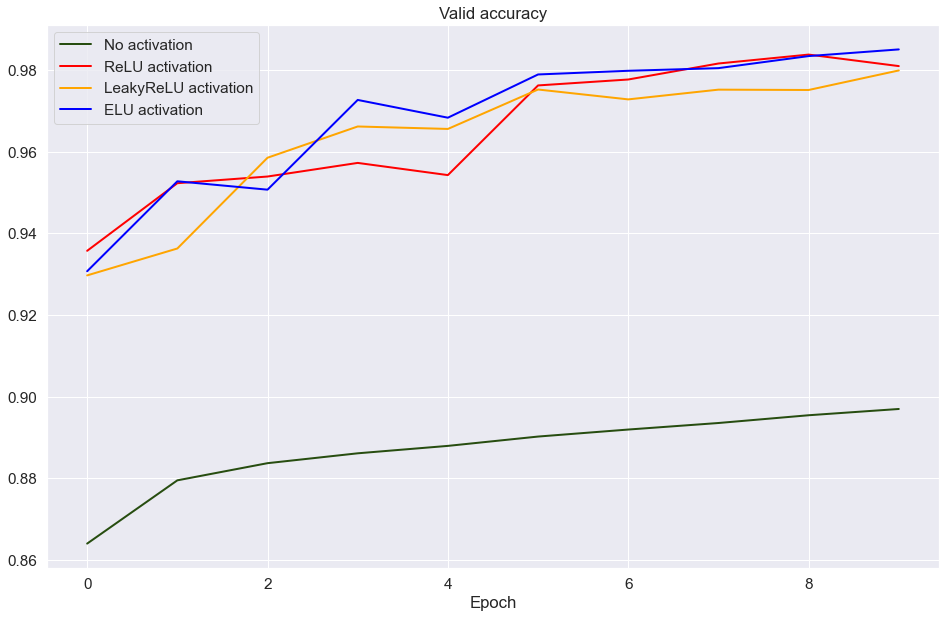

In [40]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2, color=(np.random.random(3)))
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2, color='red')
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2, color='orange')
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2, color='blue')
plt.legend()
plt.xlabel("Epoch")
plt.show()

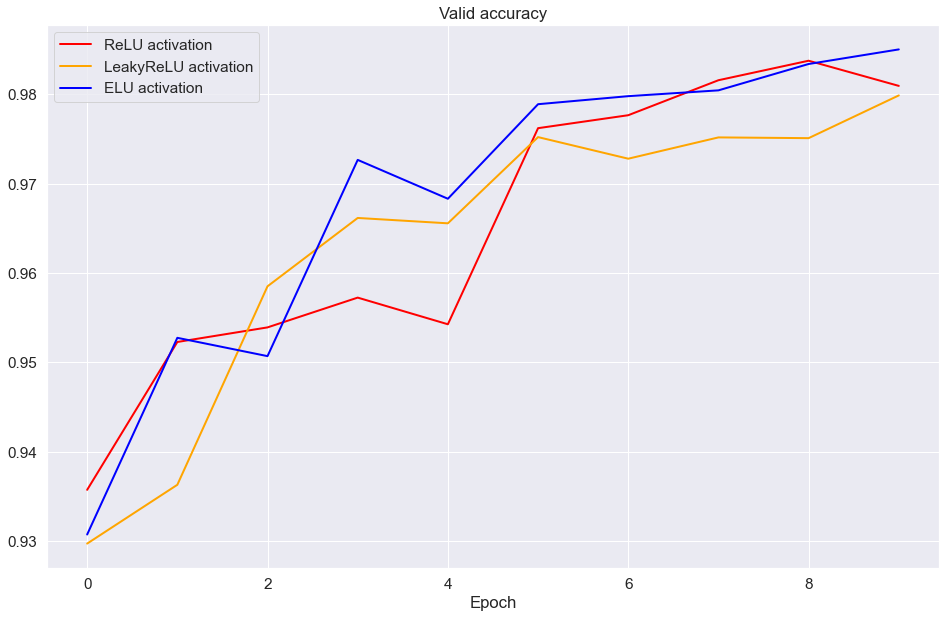

In [41]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2, color='red')
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2, color='orange')
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2, color='blue')
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [42]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-03-30 19:21:05--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Распознаётся img.the-village.kz (img.the-village.kz)… 144.76.208.75
Подключение к img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 301 Moved Permanently
Адрес: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [переход]
--2022-03-30 19:21:05--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Распознаётся img.the-village-kz.com (img.the-village-kz.com)… 144.76.208.75
Подключение к img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 49337 (48K) [image/jpeg]
Сохранение в: «sample_photo.jpg»

sample_photo.jpg    100%[===================>]  48,18K  --.-KB/s    за 0,09s   

2022-03-30 19:21:05 (531 KB/s) - «sample_

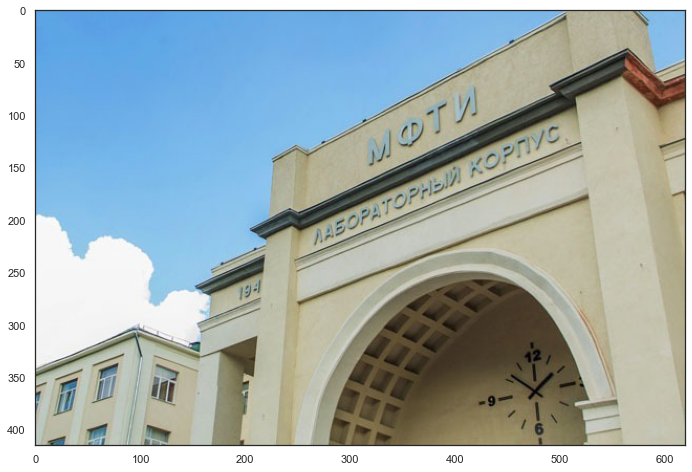

In [43]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [44]:
kernels = [[[0, 0, 0], [0, 1, 0], [0, 0, 0]],
          [[0, 1, 0], [0, -2, 0], [0, 1, 0]],
          [[0, 0, 0], [1, -2, 1], [0, 0, 0]],
          [[0, 1, 0], [1, -4, 1], [0, 1, 0]],
          [[0, -1, 0],[-1, 5, -1],[0, -1, 0]],
          [[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]]
]
symbols = ['А', 'Б', "В", "Г", "Д", "Е"]

In [45]:
def get_image(RGB_img, kernel):
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    kernel = torch.tensor(kernel).reshape(1, 1, 3, 3).type(torch.float32)
    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = F.conv2d(img_t, kernel)[0]  #
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3

    return result_np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


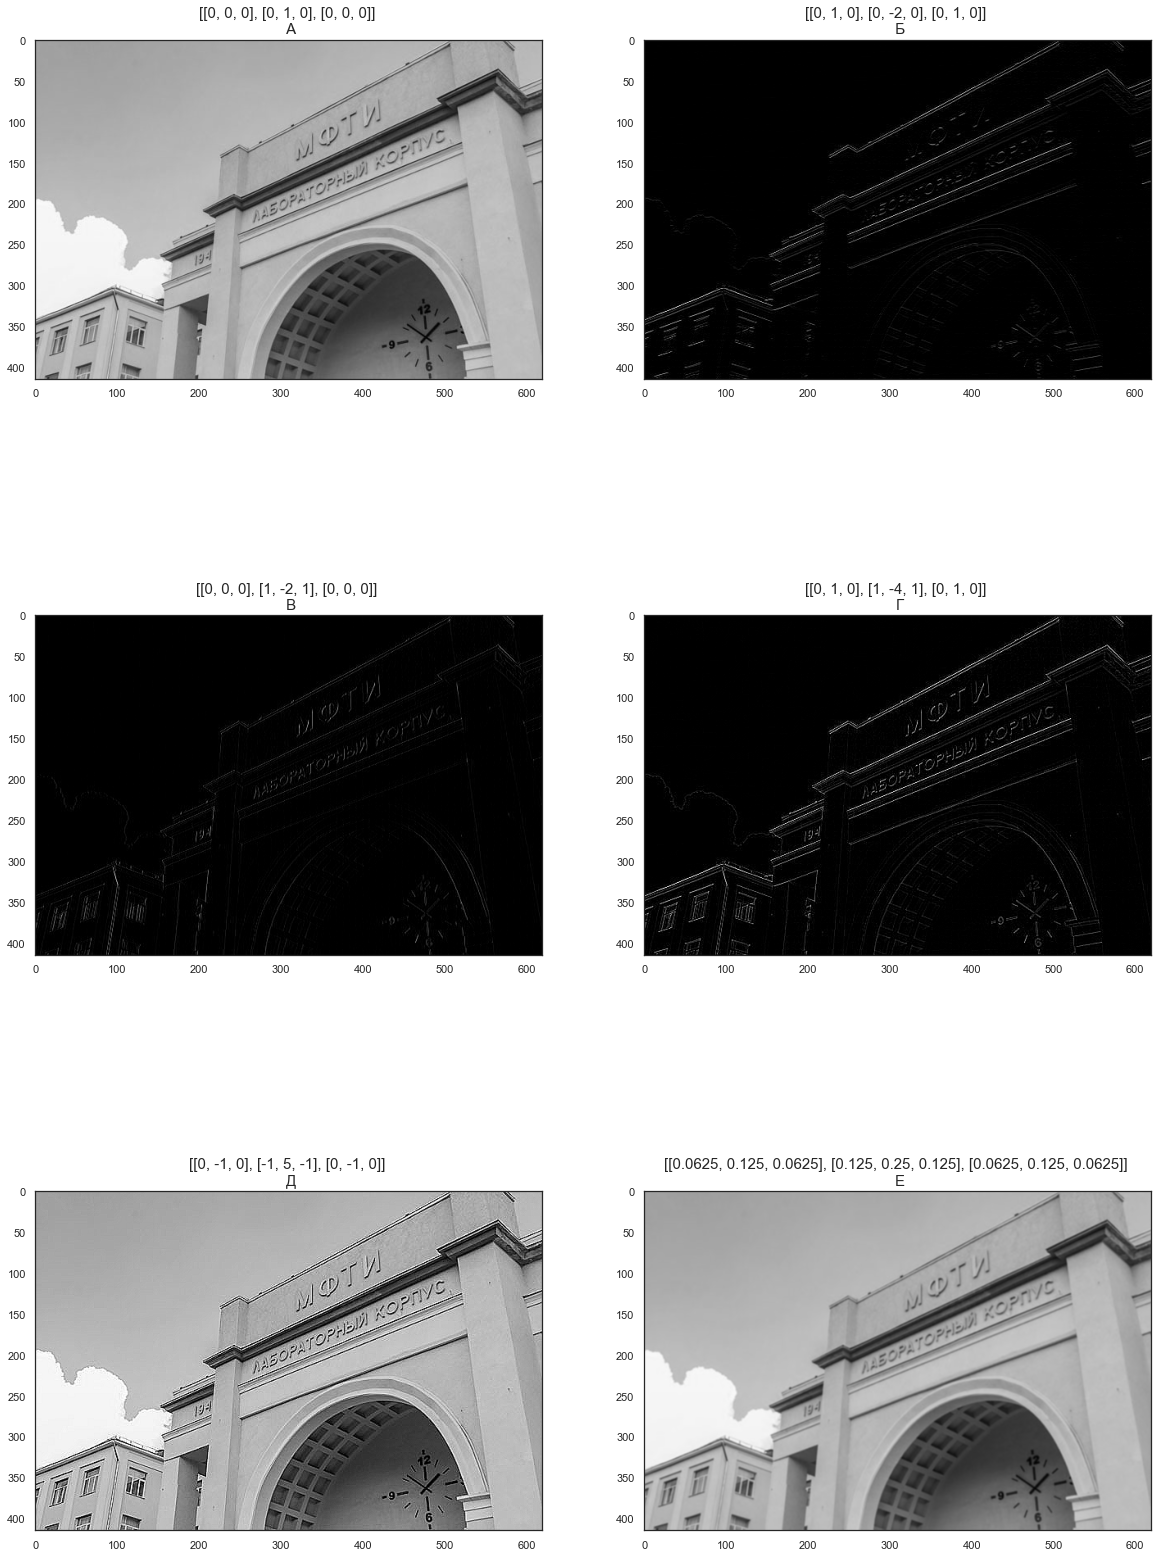

In [46]:
fig, axes = plt.subplots(3, 2, figsize=(20, 30))
ax = axes.ravel()
for i in range(6):
    ax[i].imshow(get_image(RGB_img, kernels[i]))
    ax[i].set_title(f'{kernels[i]} \n {symbols[i]}', fontsize=15)

Поиграться с ядрами можно на этом сайте:
https://setosa.io/ev/image-kernels/ 

Примеры и объяснение на сайте гимпа: https://docs.gimp.org/2.8/en/plug-in-convmatrix.html



**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие E

2) Увеличение резкости Д

3) Тождественное преобразование А

4) Выделение вертикальных границ В

5) Выделение горизонтальных границ Б

6) Выделение границ Г

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [47]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.act1 = nn.ReLU() #why its not tahn?
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2)) #originally it was average pooling
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(400, 120) # 16 5 5 = 400
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

In [48]:
model = LeNet()

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [50]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:

            if k == "train":
                optimizer.zero_grad()
                model.train() #train mode on
                outp = model.forward(x_batch)
            else:
                model.eval() #train mode off
                with torch.no_grad(): #for faster calculations
                    outp = model.forward(x_batch)

            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum().item() #number of right answers for current batch
            all = len(x_batch) #number of objects in c batch
            epoch_correct += correct
            epoch_all += all

            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step() #updates the weights
                
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9305333333333333
Loader: valid. Accuracy: 0.96135
Epoch: 2
Loader: train. Accuracy: 0.9758166666666667
Loader: valid. Accuracy: 0.9792666666666666
Epoch: 3
Loader: train. Accuracy: 0.9808666666666667
Loader: valid. Accuracy: 0.98435
Epoch: 4
Loader: train. Accuracy: 0.98345
Loader: valid. Accuracy: 0.9868833333333333
Epoch: 5
Loader: train. Accuracy: 0.9854166666666667
Loader: valid. Accuracy: 0.9884833333333334
Epoch: 6
Loader: train. Accuracy: 0.9869333333333333
Loader: valid. Accuracy: 0.9887
Epoch: 7
Loader: train. Accuracy: 0.98775
Loader: valid. Accuracy: 0.9881833333333333
Epoch: 8
Loader: train. Accuracy: 0.9888
Loader: valid. Accuracy: 0.98775
Epoch: 9
Loader: train. Accuracy: 0.9898166666666667
Loader: valid. Accuracy: 0.98785
Epoch: 10
Loader: train. Accuracy: 0.9904666666666667
Loader: valid. Accuracy: 0.9896833333333334


In [51]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

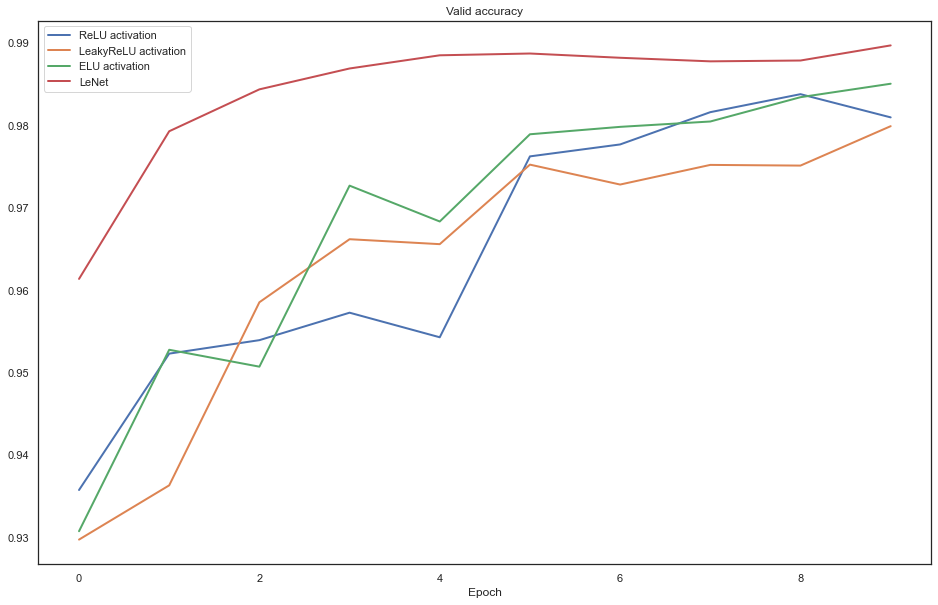

In [52]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**
0.99

In [65]:
import platform
 
my_system = platform.uname()

In [66]:
[print(i) for i in my_system]

Darwin
192.168.1.9
21.3.0
Darwin Kernel Version 21.3.0: Wed Jan  5 21:37:58 PST 2022; root:xnu-8019.80.24~20/RELEASE_ARM64_T8101
x86_64
i386


[None, None, None, None, None, None]